In [158]:
# Importing Packages

import nltk #Tokenizing
import re #Preprocessing
import matplotlib.pyplot as plt
import bs4 as bs
import urllib.request #Scraping
import heapq #getting the top k largest sentences

# Importing classes within the packages

from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords #Don't consider stopwords in histogram
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# We specify the directory where the transcripts are
file_directory = 'data/transcripts'
 
# We include those filenames ending with '.txt'.
filename_pattern = '.+\.txt'
my_corpus = PlaintextCorpusReader(file_directory, filename_pattern)

In [2]:
print(my_corpus.fileids())

# This is for future use to apply the code to all the text files in the folder

['01_10_15.txt', '19_08_09.txt']


In [121]:
# Extract sentences

sentences = my_corpus.sents('19_08_09.txt')
sent_list=[] # A list of all sentences in the transcript

for key1 in sentences:
    s=""
    for key2 in key1:
        s=s+key2+" "
    sent_list.append(s)

In [57]:
# Extract words from text file

transcript01 = my_corpus.words('19_08_09.txt')
print(transcript01)

# Here, we need to rmeove the punctuation marks from the list.
# So, we adopt a different approach using strings

['"', 'Sir', ',', 'I', 'had', 'not', 'intended', 'to', ...]


In [123]:
# Reading the text file

data=''
with open('data/transcripts/19_08_09.txt','r') as file:
    for line in file:
        s = str(line).strip()
        data = data + s + ' '
        
data = data.lower() # Contains all the data in the transcript as a string

In [59]:
data_split = data.split(" ")
print(len(data_split))

912


In [125]:
# Removing punctuations and only considering words

pattern = r"\w+"
reg_split = re.findall(pattern,data) # A list of all words in the transcript

print(len(reg_split)) 

887


In [27]:
# Tokenizing all the data

tokenizer = RegexpTokenizer(r'\w+')

data_tokens = tokenizer.tokenize(data)

print(len(data_tokens))

887


In [28]:
# Now we remove stopwords from the data

stop_words = stopwords.words('english')

clean_data = []
print("Before removing stopwords: " , len(data_tokens))

for w in data_tokens:
    if w not in stop_words:
        clean_data.append(w)        

print("After removing stopwords: " , len(clean_data))

Before removing stopwords:  887
After removing stopwords:  410


In [71]:
# We stem the data using Porter Stemmer

stemmed_data=[]
stemmer = PorterStemmer()

for w in clean_data:
    stemmed_data.append(stemmer.stem(w))
    
print(len(stemmed_data))

410


In [30]:
# Attach Parts of Speech to each word belonging to the clean data

pos_data = pos_tag(clean_data)
print(len(pos_data))

410


In [69]:
# We simplify the Parts of Speech tags
# We want to convert NNS to n and VBD to v

data_output=[]

for w in pos_data:
    data_output.append((w[0], w[1][0].lower()))

print(len(data_output))

410


In [78]:
# We use a Word Lemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_data=[]

for w in clean_data: 
    lemmatized_data.append(lemmatizer.lemmatize(w))

print(len(lemmatized_data))

410


In [93]:
# We combine the POS Tags and Lemmatized data

lemma_output_data = []
lemma_words=[]

for w in data_output:
    word = w[0]
    pos_word = w[1]
    lemma = word
    if pos_word in ['a', 's', 'r', 'n', 'v']:
        lemma = lemmatizer.lemmatize(word, pos=pos_word)
        lemma_words.append(lemma)
    
    #return (word, pos_tag, lemma)
    lemma_output_data.append((word,pos_word,lemma))
    
print(len(lemma_output_data))

410


In [94]:
# Getting frequencies

data_freq=[]

for lemma_tag in lemma_output_data:
    data_freq.append(lemma_tag[2])

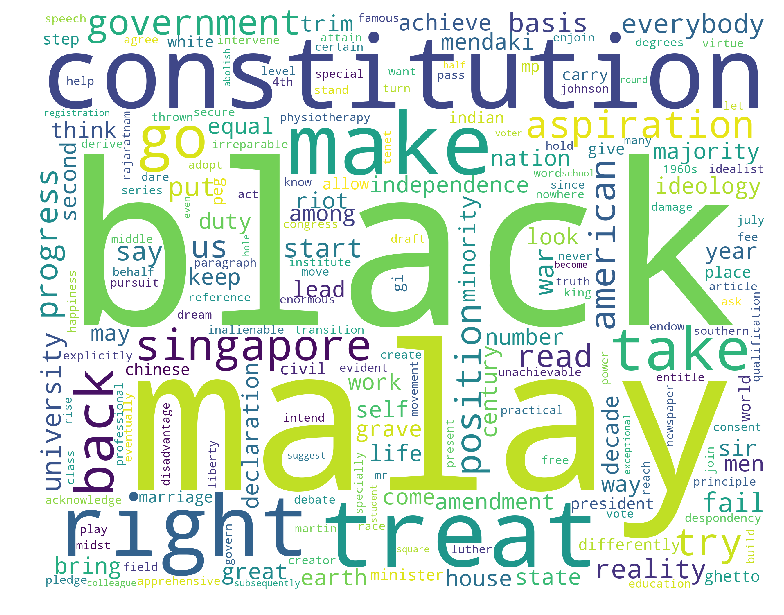

In [95]:
def word_cloud(lemma_words, color = 'black'):
    words = ' '.join(lemma_words)
    wordcloud = WordCloud(background_color=color,width=2500,height=2000).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
word_cloud(data_freq,'white')

In [156]:
fdist = nltk.FreqDist(lemma_words)
freq_list=(fdist.most_common())
print(freq_list)

freq_dict={}

for i in freq_list:
    freq_dict[i[0]]=i[1]

[('malay', 8), ('constitution', 7), ('treat', 5), ('make', 5), ('right', 5), ('take', 5), ('go', 5), ('get', 5), ('black', 5), ('back', 4), ('singapore', 4), ('aspiration', 4), ('try', 4), ('government', 4), ('position', 4), ('read', 3), ('everybody', 3), ('reality', 3), ('university', 3), ('put', 3), ('say', 3), ('basis', 3), ('fail', 3), ('war', 3), ('think', 2), ('house', 2), ('riot', 2), ('independence', 2), ('majority', 2), ('way', 2), ('come', 2), ('trim', 2), ('work', 2), ('achieve', 2), ('keep', 2), ('nation', 2), ('amendment', 2), ('progress', 2), ('year', 2), ('look', 2), ('minority', 2), ('state', 2), ('lead', 2), ('grave', 2), ('number', 2), ('decade', 2), ('century', 2), ('declaration', 2), ('men', 2), ('life', 2), ('differently', 2), ('place', 2), ('president', 2), ('allow', 2), ('minister', 2), ('marriage', 2), ('step', 2), ('world', 2), ('carry', 2), ('give', 2), ('gi', 2), ('ghetto', 2), ('start', 2), ('sir', 1), ('intend', 1), ('debate', 1), ('physiotherapy', 1), ('ne

In [115]:
# Building the weighted histogram

# You calculate the number of occurences of each word
# In the end divide all values by max value so range is (0,1)

maxCount = max(freq_dict.values())
for key in freq_dict.keys():
    freq_dict[key] = freq_dict[key]/maxCount

In [130]:
# Sentence scores

# Add score for each word in a sentence to get sentence score

sent2score = {}
sentCount=0
for sentence in sent_list:
    for word in nltk.word_tokenize(sentence.lower()):
        if(len(sentence.split(' ')) < 25):  #Sent < 30 words
            #Check such that it's not biased towards long sentences over important sentences
            if word in freq_dict.keys():
                sentCount+=freq_dict[word]
            else:
                sentCount+=0
    sent2score[sentence] = sentCount

In [137]:
# Getting summary

best_sentences = heapq.nlargest(100, sent2score, key=sent2score.get)

In [160]:
# Clustering- on the lemmatized words

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(lemma_words)

true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 malay
 black
 treat
 right
 aspiration
 try
 government
 singapore
 position
 reality
Cluster 1:
 constitution
 year
 fight
 government
 govern
 gi
 ghetto
 fund
 foundation
 forward
Cluster 2:
 make
 year
 fee
 govern
 gi
 ghetto
 fund
 foundation
 forward
 flaw
Cluster 3:
 declaration
 year
 field
 government
 govern
 gi
 ghetto
 fund
 foundation
 forward
Cluster 4:
 stay
 year
 field
 govern
 gi
 ghetto
 fund
 foundation
 forward
 flaw
